In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
path="/content/drive/My Drive/crypto_data"
files=["BCH-USD","BTC-USD","ETH-USD","LTC-USD"]
main_df=pd.DataFrame()
for file in files:
  df=pd.read_csv((os.path.join(path,file)+".csv"),names=["timestamp","low","high","open","close","volume"])
  df=df[["timestamp","close","volume"]]
  ## use need only close and volume column  for prediction
  df.rename(columns={"close":file+"_close","volume":file+"_volume"},inplace=True)
  df.set_index("timestamp",inplace=True)
  if len(main_df)==0:
    main_df=df
  else:
    main_df=main_df.join(df)
 
main_df.head()


,BCH-USD_close,BCH-USD_volume,BTC-USD_close,BTC-USD_volume,ETH-USD_close,ETH-USD_volume,LTC-USD_close,LTC-USD_volume
timestamp,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978


In [3]:
main_df.isnull().sum()

BCH-USD_close        0
BCH-USD_volume       0
BTC-USD_close     5122
BTC-USD_volume    5122
ETH-USD_close      195
ETH-USD_volume     195
LTC-USD_close      836
LTC-USD_volume     836
dtype: int64

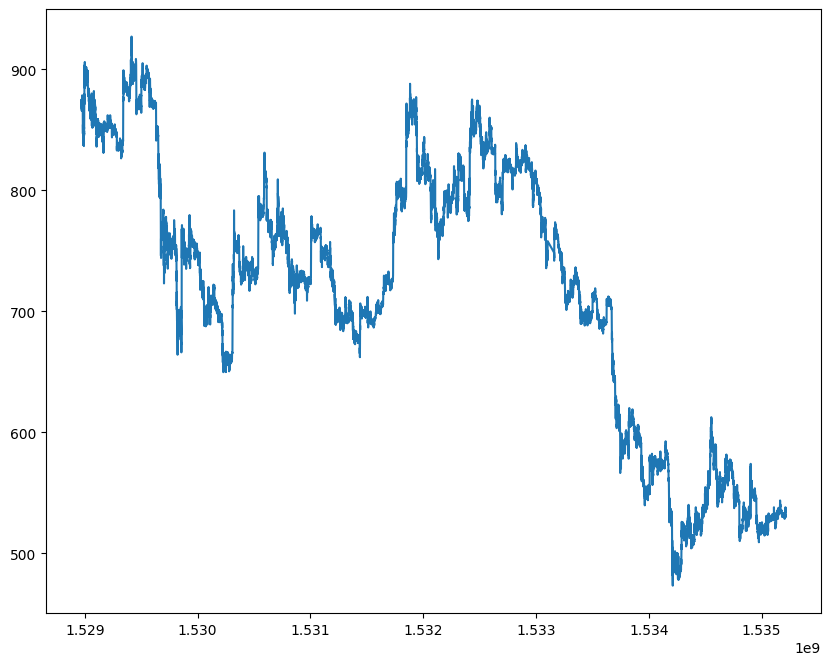

In [4]:
plt.figure(figsize=(10,8),dpi=100)
plt.plot(main_df["BCH-USD_close"])

In [5]:
seq_len=60   ##60 min
future_period_predict=3  ##3 min
currency="LTC-USD"

In [6]:
def fun(current,future):
  if float(future)> float(current):
    return 1
  else:
    return 0

In [7]:
main_df["future"]=main_df[f"{currency}_close"].shift(-future_period_predict)
main_df[[f"{currency}_close","future"]]

,LTC-USD_close,future
timestamp,,
1528968660,96.580002,96.500000
1528968720,96.660004,96.389999
1528968780,96.570000,96.519997
1528968840,96.500000,96.440002
1528968900,96.389999,96.470001
...,...,...
1535215020,58.009998,58.080002
1535215080,58.020000,58.090000
1535215140,58.020000,NaN


In [8]:
main_df["target"]=list(map(fun,main_df[f"{currency}_close"],main_df.future))

In [9]:
main_df[[f"{currency}_close","future","target"]]

,LTC-USD_close,future,target
timestamp,,,
1528968660,96.580002,96.500000,0
1528968720,96.660004,96.389999,0
1528968780,96.570000,96.519997,0
1528968840,96.500000,96.440002,0
1528968900,96.389999,96.470001,1
...,...,...,...
1535215020,58.009998,58.080002,1
1535215080,58.020000,58.090000,1
1535215140,58.020000,NaN,0


In [10]:
time=sorted(main_df.index.values)
time_last5_per=time[-int(.05*len(main_df))]
time_last5_per

1534879920

In [11]:
validation_data=main_df[(main_df.index.values >  time_last5_per)]

In [12]:
train_data=main_df[(main_df.index.values < time_last5_per)]

In [13]:
#### normalization ,scaling of data
from sklearn import preprocessing
import random
from collections import deque

In [14]:
def preprocessing_data(df):
  df=df.drop("future",1)

  for col in df.columns:
    if col !="target":
      df[col]=df[col].pct_change()
      df.dropna(inplace=True)
      df[col]=preprocessing.scale(df[col].values)
  df.dropna(inplace=True)

  seq_data=[]
  prev_min=deque(maxlen=seq_len)
  for i in df.values:
    prev_min.append([n for n in i[:-1]])
    if len(prev_min)==seq_len:
      seq_data.append([np.array(prev_min),i[-1]])
  random.shuffle(seq_data)

  incre=[]
  decre=[]
  for seq,target in seq_data:
    if target==0:
      decre.append([seq,target])
    else:
      incre.append([seq,target])
  random.shuffle(incre)
  random.shuffle(decre)

  lower=min(len(incre),len(decre))
  incre=incre[:lower]
  decre=decre[:lower]
  
  seq_data=incre+decre
  random.shuffle(seq_data)
  
  X=[]
  y=[]

  for seq,target in seq_data:
   X.append(seq)
   y.append(target)
  
  return  np.array(X),y

In [15]:
preprocessing_data(train_data)

(array([[[ 2.85007626e-01, -6.20698557e-03, -1.41358062e+00, ...,
          -4.94105899e-02, -2.11964953e+00, -1.21232076e-01],
         [ 2.37103930e-03, -6.23249980e-03,  6.81050614e-01, ...,
          -4.41074008e-02,  4.03796886e-01, -1.01259657e-01],
         [ 2.37103930e-03, -6.23304555e-03,  3.86067411e-01, ...,
          -1.08334927e-02,  2.39949230e+00,  4.64870633e-02],
         ...,
         [ 2.37103930e-03, -6.21989885e-03, -7.62471862e-02, ...,
          -2.25241262e-02, -1.27814573e-01, -1.17430630e-01],
         [-4.06973818e+00, -3.09004631e-03, -1.16460918e+00, ...,
          -8.49718602e-03, -3.92206919e-01, -3.52195100e-02],
         [ 2.37103930e-03, -6.24032181e-03,  2.40952952e-01, ...,
          -4.75291488e-02, -1.27907600e-01, -1.13641070e-01]],
 
        [[-1.12264684e-02, -6.23468426e-03, -3.22571839e-01, ...,
           4.24825119e-02,  4.41944291e-03, -5.38567492e-02],
         [ 2.37103930e-03,  1.05974204e-03, -4.62173322e-01, ...,
          -4.76788406

In [16]:
X_train,y_train=preprocessing_data(train_data)
X_test,y_test=preprocessing_data(validation_data)
print(len(X_train),len(X_test))
print(y_train.count(0),y_train.count(1))

69400 3688
34700 34700


In [17]:
Epochs=10
Batch_Size=64

import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LSTM
from tensorflow.keras.models import  Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [18]:
model=Sequential()
model.add(CuDNNLSTM(256,input_shape=X_train.shape[1:],return_sequences=True))
model.add(Dropout(.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256,return_sequences=True))
model.add(Dropout(.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256))
model.add(Dropout(.2))
model.add(BatchNormalization())

model.add(Dense(128,activation="relu"))
model.add(Dropout(.2))


model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])


In [19]:
history=model.fit(X_train,np.array(y_train),batch_size=Batch_Size,epochs=Epochs,validation_data=(X_test,np.array(y_test)))

Epoch 1/10
1085/1085 [==============================] - 35s 32ms/step - loss: 0.7127 - accuracy: 0.5112 - val_loss: 1.5999 - val_accuracy: 0.4875
Epoch 2/10
1085/1085 [==============================] - 26s 24ms/step - loss: 0.6916 - accuracy: 0.5335 - val_loss: 0.6950 - val_accuracy: 0.5203
Epoch 3/10
1085/1085 [==============================] - 26s 24ms/step - loss: 0.6871 - accuracy: 0.5466 - val_loss: 0.6850 - val_accuracy: 0.5537
Epoch 4/10
1085/1085 [==============================] - 26s 24ms/step - loss: 0.6884 - accuracy: 0.5423 - val_loss: 0.6884 - val_accuracy: 0.5282
Epoch 5/10
1085/1085 [==============================] - 26s 24ms/step - loss: 0.6854 - accuracy: 0.5541 - val_loss: 0.6802 - val_accuracy: 0.5491
Epoch 6/10
1085/1085 [==============================] - 26s 24ms/step - loss: 0.6837 - accuracy: 0.5577 - val_loss: 0.7075 - val_accuracy: 0.5363
Epoch 7/10
1085/1085 [==============================] - 26s 24ms/step - loss: 0.6831 - accuracy: 0.5609 - val_loss: 0.6773 -

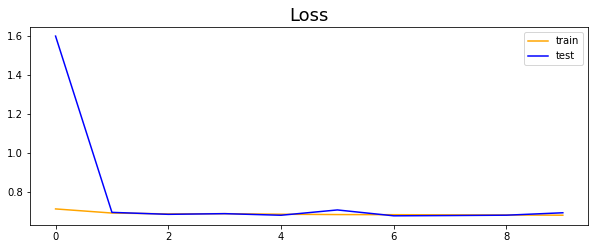

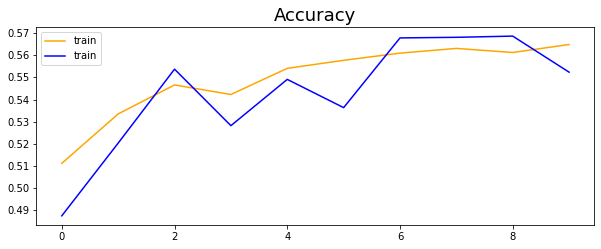

In [20]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(history.history["loss"],label="train",color="orange")
plt.plot(history.history["val_loss"],label="test",color="blue")
plt.title("Loss",fontsize=18)
plt.legend()
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(212)
plt.plot(history.history["accuracy"],label="train",color="orange")
plt.plot(history.history["val_accuracy"],label="train",color="blue")
plt.title("Accuracy",fontsize=18)
plt.legend()
plt.show()